# **Cassava Stacking Ensemble CNN**
2021/02/14 written by T.Yonezu

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import glob 
import os
from tqdm import tqdm

from cassava_dataset import *
from augmentation import *
from my_nn_trainer import *
from my_loss import BiTemperedLogisticLoss

import warnings
warnings.simplefilter('ignore')

In [2]:
INPUT_DIR = os.path.join("..","..","input")

### **Configuration**

In [3]:
OPT_NAME = "Adam"

LOSS_NAME = "BiTLLoss"
#LOSS_NAME = "CELoss"

BATCH_SIZE = 1000

### **make Dataset**

In [4]:
#glob.glob(os.path.join(INPUT_DIR,"stacking_ensemble_data","*"))
model_list = [
 '..\\..\\input\\stacking_ensemble_data\\resnet50',
# '..\\..\\input\\stacking_ensemble_data\\resnext50_32x4d',
# '..\\..\\input\\stacking_ensemble_data\\seresnext50_32x4d',
 '..\\..\\input\\stacking_ensemble_data\\tf_efficientnet_b1_ns',
# '..\\..\\input\\stacking_ensemble_data\\tf_efficientnet_b3_ns',
 '..\\..\\input\\stacking_ensemble_data\\tf_efficientnet_b4_ns',
 '..\\..\\input\\stacking_ensemble_data\\tf_efficientnet_b5_ns'
]

model_list

['..\\..\\input\\stacking_ensemble_data\\resnet50',
 '..\\..\\input\\stacking_ensemble_data\\tf_efficientnet_b1_ns',
 '..\\..\\input\\stacking_ensemble_data\\tf_efficientnet_b4_ns',
 '..\\..\\input\\stacking_ensemble_data\\tf_efficientnet_b5_ns']

In [5]:
def read_csv(path):
    df = pd.read_csv(path,header=None,names=["label","c0_proba","c1_proba","c2_proba","c3_proba","c4_proba"])
    return df

df = []
use_col = ["c0_proba","c1_proba","c2_proba","c3_proba","c4_proba"]
for p in model_list:
    
    model_name = p.split(os.path.sep)[-1]
    
    csv_df = pd.concat(map(read_csv,np.sort(glob.glob(os.path.join(p,"*.csv")))))
    csv_df = csv_df.reset_index(drop=True)
    
    label = csv_df["label"]
    csv_df = csv_df[use_col]
    csv_df.columns = [model_name+"-"+c for c in csv_df.columns]
    
    df.append(csv_df)
    
df = pd.concat(df,axis=1)
df["label"] = label

display(df)

,resnet50-c0_proba,resnet50-c1_proba,resnet50-c2_proba,resnet50-c3_proba,resnet50-c4_proba,tf_efficientnet_b1_ns-c0_proba,tf_efficientnet_b1_ns-c1_proba,tf_efficientnet_b1_ns-c2_proba,tf_efficientnet_b1_ns-c3_proba,tf_efficientnet_b1_ns-c4_proba,...,tf_efficientnet_b4_ns-c1_proba,tf_efficientnet_b4_ns-c2_proba,tf_efficientnet_b4_ns-c3_proba,tf_efficientnet_b4_ns-c4_proba,tf_efficientnet_b5_ns-c0_proba,tf_efficientnet_b5_ns-c1_proba,tf_efficientnet_b5_ns-c2_proba,tf_efficientnet_b5_ns-c3_proba,tf_efficientnet_b5_ns-c4_proba,label
0,9.660430e-10,1.476140e-08,2.769000e-07,1.000000,2.211294e-09,7.780925e-07,3.205784e-07,2.359537e-06,0.999986,1.061610e-05,...,8.827715e-12,4.113909e-11,1.000000,9.307120e-11,1.975049e-07,5.442644e-07,1.253155e-06,0.999997,6.288963e-07,3.0
1,1.357933e-05,2.775435e-05,9.884184e-01,0.000613,1.092685e-02,6.645226e-04,4.767717e-04,9.597803e-01,0.003533,3.554523e-02,...,2.008299e-03,9.527927e-01,0.004517,3.638878e-02,8.024587e-04,4.801068e-04,8.903761e-01,0.008444,9.989742e-02,2.0
2,2.317385e-09,1.064725e-05,3.250399e-06,0.999986,5.376766e-10,6.412039e-08,1.219352e-06,1.929583e-06,0.999997,1.245647e-07,...,2.274946e-04,4.506631e-04,0.999311,6.188137e-06,3.603334e-07,2.593379e-04,3.810736e-05,0.999701,7.166085e-07,3.0
3,1.630498e-09,2.336278e-07,5.083764e-06,0.999995,1.484585e-09,3.279894e-11,5.130617e-10,7.625981e-11,1.000000,5.450043e-11,...,7.792757e-10,5.419011e-10,1.000000,6.472086e-11,9.910337e-09,5.003481e-08,2.118291e-09,1.000000,5.871680e-09,3.0
4,1.024597e-07,9.999533e-01,7.167890e-07,0.000046,2.768457e-08,1.325643e-04,9.992921e-01,9.812938e-05,0.000322,1.549834e-04,...,9.979163e-01,8.632378e-04,0.000380,4.697928e-04,2.218937e-05,9.999232e-01,1.520590e-05,0.000007,3.269783e-05,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21392,2.405553e-04,5.428724e-01,1.357525e-03,0.455362,1.672799e-04,6.438458e-04,8.206483e-01,1.982889e-04,0.167705,1.080508e-02,...,9.593705e-01,1.881186e-03,0.015611,1.849925e-02,2.890997e-04,9.958012e-01,4.173641e-04,0.002747,7.454866e-04,1.0
21393,1.448970e-02,7.055876e-02,1.256430e-02,0.708801,1.935862e-01,2.199224e-06,8.800630e-06,2.612033e-05,0.999938,2.507066e-05,...,6.434574e-05,6.807243e-04,0.999151,9.003587e-05,3.123372e-04,1.989218e-04,6.228488e-03,0.987249,6.011625e-03,3.0
21394,1.087766e-07,3.949097e-05,1.429512e-02,0.985665,9.159906e-08,6.572399e-05,1.623268e-05,5.387643e-02,0.945702,3.396930e-04,...,1.373490e-05,4.113743e-03,0.995844,1.490909e-05,4.602800e-04,4.804888e-04,3.121431e-02,0.967263,5.818484e-04,3.0
21395,3.769438e-08,9.999952e-01,2.560512e-08,0.000005,3.533622e-09,4.419872e-05,9.985771e-01,1.334885e-05,0.001296,6.967030e-05,...,9.977456e-01,3.269041e-05,0.002021,1.602805e-04,1.071888e-05,9.998552e-01,1.016827e-05,0.000068,5.545440e-05,1.0


In [6]:
class StackingDataset(data.Dataset):
    def __init__(self, df,features,target):
        self.df = df
        self.target = target
        self.features = features
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        label = self.df[self.target].values[index]
        img = np.array(self.df[features].iloc[index])
        img = img.reshape([-1,5])[np.newaxis,:,:]
        img = torch.from_numpy(img)

        return img.float(), int(label)

features = [c for c in df.columns if "proba" in c]
target = "label"


from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, 
                                     test_size=0.2,
                                     random_state=2021,
                                     stratify=df[target])

train_dataloader = DataLoader(StackingDataset(train_df,features,target),
                              batch_size=BATCH_SIZE,
                              shuffle=True)

valid_dataloader = DataLoader(StackingDataset(test_df,features,target),
                              batch_size=BATCH_SIZE)

### **2D-CNN for Stacking Ensemble**

In [7]:
class my2DCNN(nn.Module):
    def __init__(self,model_num):
        super().__init__()
        
        self.feature = nn.Sequential(
            nn.Conv2d(1,8,kernel_size=(1,3),stride=1,padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(8,16,kernel_size=(1,3),stride=1,padding=0),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16*model_num*1,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.8),
            nn.Linear(2048,5)
        )
        
        self.model_num = model_num
        
        
    def forward(self,x):
        x = self.feature(x)
        x = x.view(-1,16*self.model_num*1)
        x = self.classifier(x)
        
        return x
    
    def check_cnn_size(self,x):
        out = self.feature(x)
        return out 


model = my2DCNN(model_num=len(model_list))
print(model)
MODEL_NAME = "2D_CNN"

my2DCNN(
  (feature): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(1, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.8, inplace=False)
    (3): Linear(in_features=2048, out_features=5, bias=True)
  )
)


### **Optimizer**

In [8]:
import torch.optim as optim
from torch import nn

lr = 0.0001
if OPT_NAME == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=lr)
if OPT_NAME == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
MODEL_NAME += "-"+OPT_NAME+"(lr%s)"%lr

### **Criterion**

In [9]:
if LOSS_NAME == "BiTLLoss":
    t1,t2,label_smoothing,num_iters,reduction = (0.2,1.2,0.01,5,"mean")
    criterion = BiTemperedLogisticLoss(t1,t2,label_smoothing,num_iters,reduction)
    MODEL_NAME = MODEL_NAME+"-"+LOSS_NAME+"(%s,%s)"%(t1,t2)
    
if LOSS_NAME == "CELoss":
    criterion = nn.CrossEntropyLoss()
    MODEL_NAME = MODEL_NAME+"-"+LOSS_NAME

### **Training**

2D_CNN-Adam(lr0.0001)-BiTLLoss(0.2,1.2)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

epoch:  0 

 > train loss: 0.475285360559916   valid loss: 0.45154132798453356
 > train acc: 0.45311678448326226   valid acc: 0.6149532710280374
 > best acc:  -inf
   ! best acc updated ! =>  0.6149532710280374


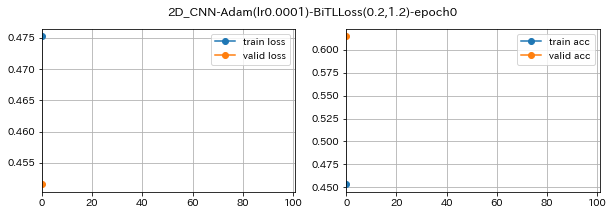

  1%|▊                                                                                 | 1/100 [00:26<42:57, 26.04s/it]

epoch:  1 



  2%|█▋                                                                                | 2/100 [00:51<42:18, 25.90s/it]

 > train loss: 0.43139455407699456   valid loss: 0.4050127434953351
 > train acc: 0.6153531576794999   valid acc: 0.6149532710280374
 > best acc:  0.6149532710280374
epoch:  2 



  3%|██▍                                                                               | 3/100 [01:16<41:35, 25.73s/it]

 > train loss: 0.3850284095222638   valid loss: 0.36001482578081506
 > train acc: 0.6149442075129987   valid acc: 0.6149532710280374
 > best acc:  0.6149532710280374
epoch:  3 



  4%|███▎                                                                              | 4/100 [01:41<40:32, 25.34s/it]

 > train loss: 0.34671888537667944   valid loss: 0.33002312634592856
 > train acc: 0.6149442075129987   valid acc: 0.6149532710280374
 > best acc:  0.6149532710280374
epoch:  4 



  5%|████                                                                              | 5/100 [02:05<39:41, 25.07s/it]

 > train loss: 0.3236978004303548   valid loss: 0.31399810815525947
 > train acc: 0.6149442075129987   valid acc: 0.6149532710280374
 > best acc:  0.6149532710280374
epoch:  5 

 > train loss: 0.3091581043861678   valid loss: 0.30031121222772333
 > train acc: 0.6149442075129987   valid acc: 0.6149532710280374
 > best acc:  0.6149532710280374


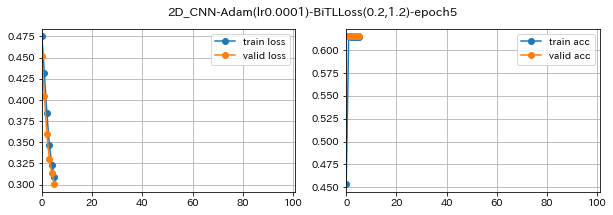

  6%|████▉                                                                             | 6/100 [02:30<39:13, 25.03s/it]

epoch:  6 



  7%|█████▋                                                                            | 7/100 [02:55<38:32, 24.87s/it]

 > train loss: 0.29510893009913375   valid loss: 0.286036308402213
 > train acc: 0.6151194718700707   valid acc: 0.6149532710280374
 > best acc:  0.6149532710280374
epoch:  7 



  8%|██████▌                                                                           | 8/100 [03:19<37:51, 24.69s/it]

 > train loss: 0.2807984239706726   valid loss: 0.2712825272127847
 > train acc: 0.6270958696033183   valid acc: 0.6149532710280374
 > best acc:  0.6149532710280374
epoch:  8 



  9%|███████▍                                                                          | 9/100 [03:43<37:17, 24.59s/it]

 > train loss: 0.26615594392479697   valid loss: 0.25656593458674776
 > train acc: 0.66717298592043   valid acc: 0.6913551401869159
 > best acc:  0.6149532710280374
   ! best acc updated ! =>  0.6913551401869159
epoch:  9 



 10%|████████                                                                         | 10/100 [04:08<36:50, 24.57s/it]

 > train loss: 0.25139829953860937   valid loss: 0.24252603558179375
 > train acc: 0.6922942104340714   valid acc: 0.6953271028037383
 > best acc:  0.6913551401869159
   ! best acc updated ! =>  0.6953271028037383
epoch:  10 

 > train loss: 0.23778213731469677   valid loss: 0.229328594475149
 > train acc: 0.6972016124320851   valid acc: 0.6981308411214954
 > best acc:  0.6953271028037383
   ! best acc updated ! =>  0.6981308411214954


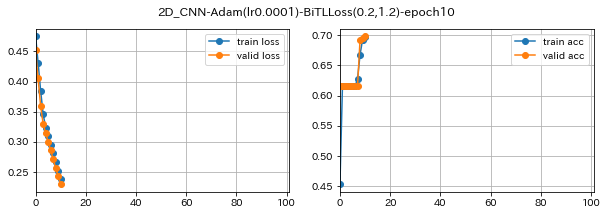

 11%|████████▉                                                                        | 11/100 [04:33<36:37, 24.69s/it]

epoch:  11 



 12%|█████████▋                                                                       | 12/100 [04:57<36:05, 24.60s/it]

 > train loss: 0.2249226988079239   valid loss: 0.21702235644665835
 > train acc: 0.7047379797861775   valid acc: 0.7011682242990654
 > best acc:  0.6981308411214954
   ! best acc updated ! =>  0.7011682242990654
epoch:  12 



 13%|██████████▌                                                                      | 13/100 [05:22<35:52, 24.74s/it]

 > train loss: 0.2127266178394984   valid loss: 0.2054476332720195
 > train acc: 0.7277560320149559   valid acc: 0.7724299065420561
 > best acc:  0.7011682242990654
   ! best acc updated ! =>  0.7724299065420561
epoch:  13 



 14%|███████████▎                                                                     | 14/100 [05:47<35:25, 24.72s/it]

 > train loss: 0.20128518501585552   valid loss: 0.19446218306216123
 > train acc: 0.7635683823099843   valid acc: 0.789018691588785
 > best acc:  0.7724299065420561
   ! best acc updated ! =>  0.789018691588785
epoch:  14 



 15%|████████████▏                                                                    | 15/100 [06:12<35:06, 24.78s/it]

 > train loss: 0.19039341221312855   valid loss: 0.18398679681470462
 > train acc: 0.7864695916340481   valid acc: 0.7925233644859813
 > best acc:  0.789018691588785
   ! best acc updated ! =>  0.7925233644859813
epoch:  15 

 > train loss: 0.18065500867215664   valid loss: 0.17413325468513452
 > train acc: 0.8187182333352807   valid acc: 0.8670560747663552
 > best acc:  0.7925233644859813
   ! best acc updated ! =>  0.8670560747663552


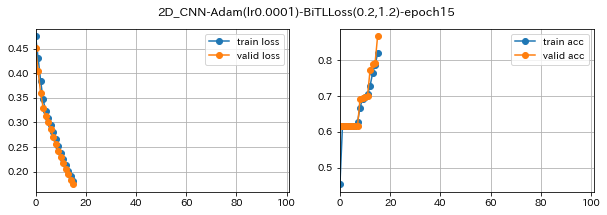

 16%|████████████▉                                                                    | 16/100 [06:37<34:41, 24.78s/it]

epoch:  16 



 17%|█████████████▊                                                                   | 17/100 [07:01<34:09, 24.69s/it]

 > train loss: 0.17100223058722264   valid loss: 0.16510639054195902
 > train acc: 0.8541216334638079   valid acc: 0.8698598130841122
 > best acc:  0.8670560747663552
   ! best acc updated ! =>  0.8698598130841122
epoch:  17 



 18%|██████████████▌                                                                  | 18/100 [07:26<33:36, 24.60s/it]

 > train loss: 0.16208833631977074   valid loss: 0.1569545824672574
 > train acc: 0.8675001460536309   valid acc: 0.8700934579439252
 > best acc:  0.8698598130841122
   ! best acc updated ! =>  0.8700934579439252
epoch:  18 



 19%|███████████████▍                                                                 | 19/100 [07:50<33:08, 24.54s/it]

 > train loss: 0.15494454765895083   valid loss: 0.1496574654478893
 > train acc: 0.8696617397908512   valid acc: 0.8705607476635514
 > best acc:  0.8700934579439252
   ! best acc updated ! =>  0.8705607476635514
epoch:  19 



 20%|████████████████▏                                                                | 20/100 [08:14<32:40, 24.51s/it]

 > train loss: 0.1480675857961822   valid loss: 0.1432213081377689
 > train acc: 0.8696033183384939   valid acc: 0.8703271028037384
 > best acc:  0.8705607476635514
epoch:  20 

 > train loss: 0.1421812845589562   valid loss: 0.13760047036910725
 > train acc: 0.8708885902903546   valid acc: 0.8703271028037384
 > best acc:  0.8705607476635514


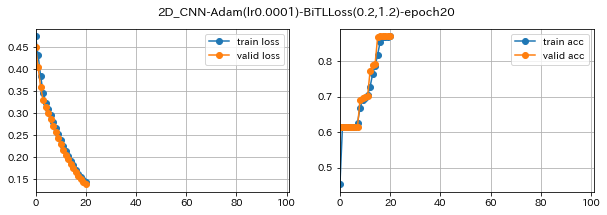

 21%|█████████████████                                                                | 21/100 [08:39<32:24, 24.61s/it]

epoch:  21 



 22%|█████████████████▊                                                               | 22/100 [09:04<31:54, 24.55s/it]

 > train loss: 0.1364510697224238   valid loss: 0.13271185372755906
 > train acc: 0.8717064906233569   valid acc: 0.8707943925233644
 > best acc:  0.8705607476635514
   ! best acc updated ! =>  0.8707943925233644
epoch:  22 



 23%|██████████████████▋                                                              | 23/100 [09:28<31:30, 24.56s/it]

 > train loss: 0.13202347739831918   valid loss: 0.128471746971117
 > train acc: 0.8711222760997839   valid acc: 0.8707943925233644
 > best acc:  0.8707943925233644
epoch:  23 



 24%|███████████████████▍                                                             | 24/100 [09:53<31:14, 24.66s/it]

 > train loss: 0.1281613284090715   valid loss: 0.12479492750401809
 > train acc: 0.871531226266285   valid acc: 0.8707943925233644
 > best acc:  0.8707943925233644
epoch:  24 



 25%|████████████████████▎                                                            | 25/100 [10:18<30:45, 24.61s/it]

 > train loss: 0.12495970430984643   valid loss: 0.1214650829679498
 > train acc: 0.8714728048139276   valid acc: 0.8710280373831776
 > best acc:  0.8707943925233644
   ! best acc updated ! =>  0.8710280373831776
epoch:  25 

 > train loss: 0.12165024186250392   valid loss: 0.11860341300195623
 > train acc: 0.8712975404568558   valid acc: 0.8712616822429906
 > best acc:  0.8710280373831776
   ! best acc updated ! =>  0.8712616822429906


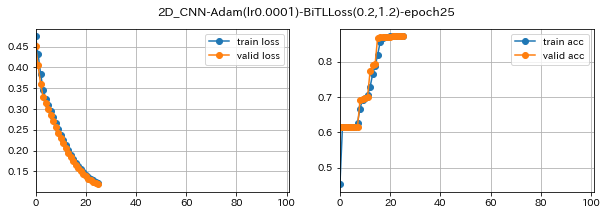

 26%|█████████████████████                                                            | 26/100 [10:43<30:39, 24.85s/it]

epoch:  26 



 27%|█████████████████████▊                                                           | 27/100 [11:08<30:12, 24.83s/it]

 > train loss: 0.1192471563951876   valid loss: 0.11597535369273658
 > train acc: 0.8728164982181457   valid acc: 0.8712616822429906
 > best acc:  0.8712616822429906
epoch:  27 



 28%|██████████████████████▋                                                          | 28/100 [11:32<29:41, 24.74s/it]

 > train loss: 0.11668525487376046   valid loss: 0.11365491980425665
 > train acc: 0.8744522988841502   valid acc: 0.8710280373831776
 > best acc:  0.8712616822429906
epoch:  28 



 29%|███████████████████████▍                                                         | 29/100 [11:57<29:10, 24.66s/it]

 > train loss: 0.11446990114426428   valid loss: 0.11157999299118453
 > train acc: 0.8766723140737279   valid acc: 0.8782710280373832
 > best acc:  0.8712616822429906
   ! best acc updated ! =>  0.8782710280373832
epoch:  29 



 30%|████████████████████████▎                                                        | 30/100 [12:21<28:44, 24.63s/it]

 > train loss: 0.11224351009455087   valid loss: 0.10969266295433044
 > train acc: 0.8815212946193842   valid acc: 0.8906542056074767
 > best acc:  0.8782710280373832
   ! best acc updated ! =>  0.8906542056074767
epoch:  30 

 > train loss: 0.11045195846024285   valid loss: 0.10805526751781179
 > train acc: 0.8866039609744698   valid acc: 0.8943925233644859
 > best acc:  0.8906542056074767
   ! best acc updated ! =>  0.8943925233644859


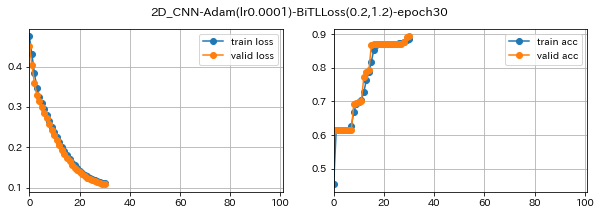

 31%|█████████████████████████                                                        | 31/100 [12:46<28:27, 24.74s/it]

epoch:  31 



 32%|█████████████████████████▉                                                       | 32/100 [13:11<28:00, 24.72s/it]

 > train loss: 0.10876866116429446   valid loss: 0.10656502042139802
 > train acc: 0.8875971256645441   valid acc: 0.8953271028037383
 > best acc:  0.8943925233644859
   ! best acc updated ! =>  0.8953271028037383
epoch:  32 



 33%|██████████████████████████▋                                                      | 33/100 [13:35<27:30, 24.63s/it]

 > train loss: 0.10754351007358252   valid loss: 0.10523010497895356
 > train acc: 0.8899924052111936   valid acc: 0.897196261682243
 > best acc:  0.8953271028037383
   ! best acc updated ! =>  0.897196261682243
epoch:  33 



 34%|███████████████████████████▌                                                     | 34/100 [14:00<27:05, 24.63s/it]

 > train loss: 0.10640333839169575   valid loss: 0.1040387626424014
 > train acc: 0.8923292633054858   valid acc: 0.8981308411214953
 > best acc:  0.897196261682243
   ! best acc updated ! =>  0.8981308411214953
epoch:  34 



 35%|████████████████████████████▎                                                    | 35/100 [14:25<26:37, 24.58s/it]

 > train loss: 0.10516069301651022   valid loss: 0.1030292944791161
 > train acc: 0.8934392709002745   valid acc: 0.8985981308411215
 > best acc:  0.8981308411214953
   ! best acc updated ! =>  0.8985981308411215
epoch:  35 

 > train loss: 0.10434237647954636   valid loss: 0.1021030412238335
 > train acc: 0.8941403283285623   valid acc: 0.8978971962616823
 > best acc:  0.8985981308411215


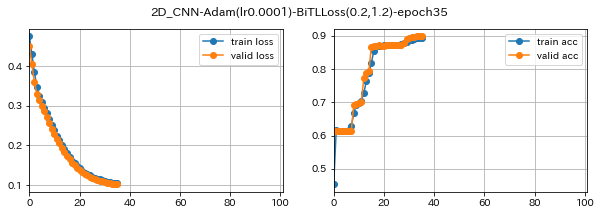

 36%|█████████████████████████████▏                                                   | 36/100 [14:49<26:15, 24.61s/it]

epoch:  36 



 37%|█████████████████████████████▉                                                   | 37/100 [15:14<25:46, 24.55s/it]

 > train loss: 0.10355323427291216   valid loss: 0.10135185446973159
 > train acc: 0.8936729567097038   valid acc: 0.8985981308411215
 > best acc:  0.8985981308411215
epoch:  37 



 38%|██████████████████████████████▊                                                  | 38/100 [15:38<25:15, 24.45s/it]

 > train loss: 0.10262876952877388   valid loss: 0.10067376341218147
 > train acc: 0.8951334930186364   valid acc: 0.8988317757009345
 > best acc:  0.8985981308411215
   ! best acc updated ! =>  0.8988317757009345
epoch:  38 



 39%|███████████████████████████████▌                                                 | 39/100 [16:02<24:52, 24.47s/it]

 > train loss: 0.10212869847342115   valid loss: 0.1000477040760985
 > train acc: 0.8956008646374949   valid acc: 0.8988317757009345
 > best acc:  0.8988317757009345
epoch:  39 



 40%|████████████████████████████████▍                                                | 40/100 [16:27<24:23, 24.39s/it]

 > train loss: 0.10118795269505543   valid loss: 0.0995584060655576
 > train acc: 0.8968277151369983   valid acc: 0.8988317757009345
 > best acc:  0.8988317757009345
epoch:  40 

 > train loss: 0.1006162417791934   valid loss: 0.0990610074634864
 > train acc: 0.8969445580417129   valid acc: 0.8988317757009345
 > best acc:  0.8988317757009345


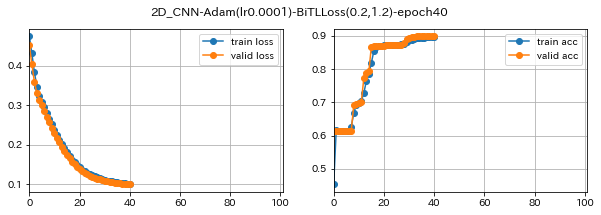

 41%|█████████████████████████████████▏                                               | 41/100 [16:51<24:02, 24.45s/it]

epoch:  41 



 42%|██████████████████████████████████                                               | 42/100 [17:16<23:38, 24.46s/it]

 > train loss: 0.10039870340063478   valid loss: 0.0987034716478018
 > train acc: 0.8961266577087106   valid acc: 0.8990654205607477
 > best acc:  0.8988317757009345
   ! best acc updated ! =>  0.8990654205607477
epoch:  42 



 43%|██████████████████████████████████▊                                              | 43/100 [17:40<23:13, 24.45s/it]

 > train loss: 0.0997379961579023   valid loss: 0.09838843359568408
 > train acc: 0.8961266577087106   valid acc: 0.8992990654205607
 > best acc:  0.8990654205607477
   ! best acc updated ! =>  0.8992990654205607
epoch:  43 



 44%|███████████████████████████████████▋                                             | 44/100 [18:05<22:51, 24.49s/it]

 > train loss: 0.09962473074454685   valid loss: 0.0980705636266236
 > train acc: 0.8962435006134253   valid acc: 0.8990654205607477
 > best acc:  0.8992990654205607
epoch:  44 



 45%|████████████████████████████████████▍                                            | 45/100 [18:29<22:24, 24.45s/it]

 > train loss: 0.09972353621585184   valid loss: 0.09776936206862191
 > train acc: 0.8957177075422095   valid acc: 0.8992990654205607
 > best acc:  0.8992990654205607
epoch:  45 

 > train loss: 0.099409052893966   valid loss: 0.09761570498486545
 > train acc: 0.8966524507799264   valid acc: 0.900233644859813
 > best acc:  0.8992990654205607
   ! best acc updated ! =>  0.900233644859813


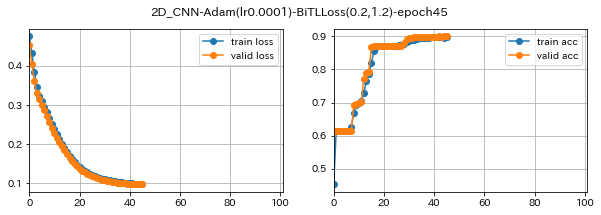

 46%|█████████████████████████████████████▎                                           | 46/100 [18:54<22:02, 24.48s/it]

epoch:  46 



 47%|██████████████████████████████████████                                           | 47/100 [19:18<21:36, 24.47s/it]

 > train loss: 0.09894976431584744   valid loss: 0.0974314017134292
 > train acc: 0.8972366653034994   valid acc: 0.900233644859813
 > best acc:  0.900233644859813
epoch:  47 



 48%|██████████████████████████████████████▉                                          | 48/100 [19:42<21:10, 24.43s/it]

 > train loss: 0.09899165756596078   valid loss: 0.09730421396616463
 > train acc: 0.8972366653034994   valid acc: 0.900233644859813
 > best acc:  0.900233644859813
epoch:  48 



 49%|███████████████████████████████████████▋                                         | 49/100 [20:07<20:45, 24.42s/it]

 > train loss: 0.09854523624238716   valid loss: 0.09711482877207693
 > train acc: 0.8981714085412164   valid acc: 0.9
 > best acc:  0.900233644859813
epoch:  49 



 50%|████████████████████████████████████████▌                                        | 50/100 [20:31<20:19, 24.40s/it]

 > train loss: 0.0986510191595693   valid loss: 0.09700303698811576
 > train acc: 0.8970029794940703   valid acc: 0.900233644859813
 > best acc:  0.900233644859813
epoch:  50 

 > train loss: 0.09876678103627101   valid loss: 0.09689829073776708
 > train acc: 0.8972950867558568   valid acc: 0.8997663551401869
 > best acc:  0.900233644859813


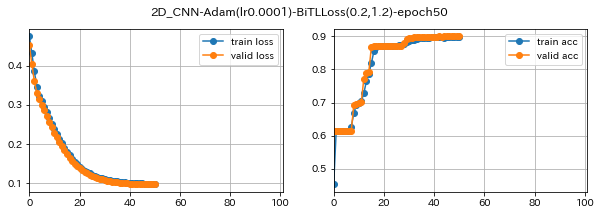

 51%|█████████████████████████████████████████▎                                       | 51/100 [20:56<20:00, 24.49s/it]

epoch:  51 



 52%|██████████████████████████████████████████                                       | 52/100 [21:20<19:34, 24.48s/it]

 > train loss: 0.09813164399767364   valid loss: 0.0967989794422533
 > train acc: 0.8969445580417129   valid acc: 0.8997663551401869
 > best acc:  0.900233644859813
epoch:  52 



 53%|██████████████████████████████████████████▉                                      | 53/100 [21:45<19:08, 24.44s/it]

 > train loss: 0.09784364201885423   valid loss: 0.09671581738463073
 > train acc: 0.898112987088859   valid acc: 0.8985981308411215
 > best acc:  0.900233644859813
epoch:  53 



 54%|███████████████████████████████████████████▋                                     | 54/100 [22:09<18:45, 24.47s/it]

 > train loss: 0.098354362351803   valid loss: 0.09663624553201354
 > train acc: 0.8965356078752118   valid acc: 0.9
 > best acc:  0.900233644859813
epoch:  54 



 55%|████████████████████████████████████████████▌                                    | 55/100 [22:33<18:17, 24.40s/it]

 > train loss: 0.0977633261524601   valid loss: 0.0966146285428065
 > train acc: 0.896769293684641   valid acc: 0.900233644859813
 > best acc:  0.900233644859813
epoch:  55 

 > train loss: 0.09808018938096082   valid loss: 0.09652986906677763
 > train acc: 0.8966524507799264   valid acc: 0.9009345794392524
 > best acc:  0.900233644859813
   ! best acc updated ! =>  0.9009345794392524


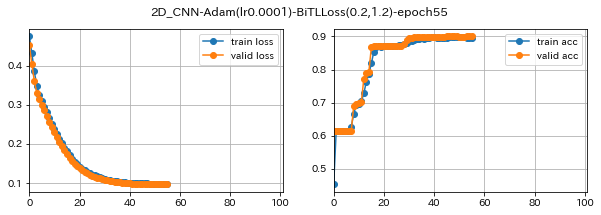

 56%|█████████████████████████████████████████████▎                                   | 56/100 [22:58<17:55, 24.45s/it]

epoch:  56 



 57%|██████████████████████████████████████████████▏                                  | 57/100 [23:23<17:32, 24.48s/it]

 > train loss: 0.09741856018405043   valid loss: 0.09646036246112574
 > train acc: 0.898112987088859   valid acc: 0.9011682242990654
 > best acc:  0.9009345794392524
   ! best acc updated ! =>  0.9011682242990654
epoch:  57 



 58%|██████████████████████████████████████████████▉                                  | 58/100 [23:47<17:06, 24.45s/it]

 > train loss: 0.09779507456719615   valid loss: 0.09642921638823002
 > train acc: 0.8967108722322837   valid acc: 0.9
 > best acc:  0.9011682242990654
epoch:  58 



 59%|███████████████████████████████████████████████▊                                 | 59/100 [24:11<16:41, 24.43s/it]

 > train loss: 0.09792636298637786   valid loss: 0.0963632557018895
 > train acc: 0.8977040369223579   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  59 



 60%|████████████████████████████████████████████████▌                                | 60/100 [24:36<16:15, 24.38s/it]

 > train loss: 0.09779424505863135   valid loss: 0.09636051583791448
 > train acc: 0.8962435006134253   valid acc: 0.9
 > best acc:  0.9011682242990654
epoch:  60 

 > train loss: 0.09767593579025005   valid loss: 0.0963472717694033
 > train acc: 0.8975871940176433   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654


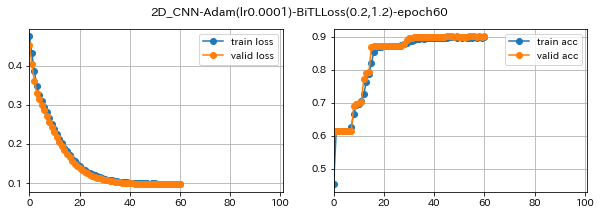

 61%|█████████████████████████████████████████████████▍                               | 61/100 [25:00<15:53, 24.45s/it]

epoch:  61 



 62%|██████████████████████████████████████████████████▏                              | 62/100 [25:25<15:28, 24.44s/it]

 > train loss: 0.09726103788188749   valid loss: 0.0962256276718924
 > train acc: 0.8982298299935736   valid acc: 0.9
 > best acc:  0.9011682242990654
epoch:  62 



 63%|███████████████████████████████████████████████████                              | 63/100 [25:49<15:02, 24.40s/it]

 > train loss: 0.0973450937094815   valid loss: 0.09617566352135667
 > train acc: 0.897528772565286   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  63 



 64%|███████████████████████████████████████████████████▊                             | 64/100 [26:13<14:39, 24.42s/it]

 > train loss: 0.09753576536318086   valid loss: 0.09617850302814324
 > train acc: 0.897353508208214   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  64 



 65%|████████████████████████████████████████████████████▋                            | 65/100 [26:38<14:14, 24.42s/it]

 > train loss: 0.0974767007211829   valid loss: 0.09620862147796934
 > train acc: 0.8972366653034994   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  65 

 > train loss: 0.09729213983698894   valid loss: 0.09616685797956502
 > train acc: 0.8977040369223579   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654


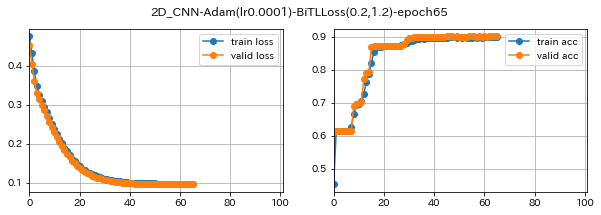

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [27:02<13:51, 24.45s/it]

epoch:  66 



 67%|██████████████████████████████████████████████████████▎                          | 67/100 [27:27<13:27, 24.46s/it]

 > train loss: 0.09741639853239394   valid loss: 0.09616223973370044
 > train acc: 0.8975871940176433   valid acc: 0.9
 > best acc:  0.9011682242990654
epoch:  67 



 68%|███████████████████████████████████████████████████████                          | 68/100 [27:51<13:01, 24.41s/it]

 > train loss: 0.097441245261953   valid loss: 0.09616877542477902
 > train acc: 0.8972366653034994   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  68 



 69%|███████████████████████████████████████████████████████▉                         | 69/100 [28:16<12:36, 24.42s/it]

 > train loss: 0.09744601513697053   valid loss: 0.09610459222414783
 > train acc: 0.8981714085412164   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  69 



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [28:40<12:11, 24.38s/it]

 > train loss: 0.09750976120157415   valid loss: 0.096041197740586
 > train acc: 0.8985803587077175   valid acc: 0.9007009345794392
 > best acc:  0.9011682242990654
epoch:  70 

 > train loss: 0.09694903180165959   valid loss: 0.09605611784157352
 > train acc: 0.8974119296605714   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654


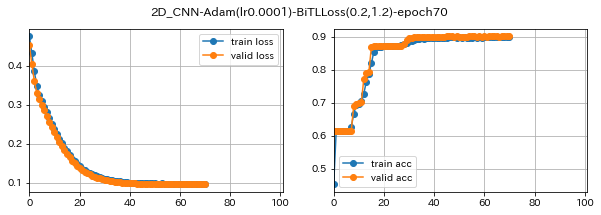

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [29:04<11:49, 24.45s/it]

epoch:  71 



 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [29:29<11:24, 24.44s/it]

 > train loss: 0.09750814733495429   valid loss: 0.09601951313910083
 > train acc: 0.8972950867558568   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  72 



 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [29:53<10:58, 24.39s/it]

 > train loss: 0.09751631185893819   valid loss: 0.09605260054084742
 > train acc: 0.8970614009464275   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  73 



 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [30:18<10:34, 24.40s/it]

 > train loss: 0.09697464458753643   valid loss: 0.09598868159211685
 > train acc: 0.8974119296605714   valid acc: 0.9009345794392524
 > best acc:  0.9011682242990654
epoch:  74 



 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [30:42<10:09, 24.37s/it]

 > train loss: 0.09707401270912916   valid loss: 0.0959964628531554
 > train acc: 0.8972950867558568   valid acc: 0.9007009345794392
 > best acc:  0.9011682242990654
epoch:  75 

 > train loss: 0.09682676705629767   valid loss: 0.09601315424264034
 > train acc: 0.8986387801600748   valid acc: 0.9011682242990654
 > best acc:  0.9011682242990654


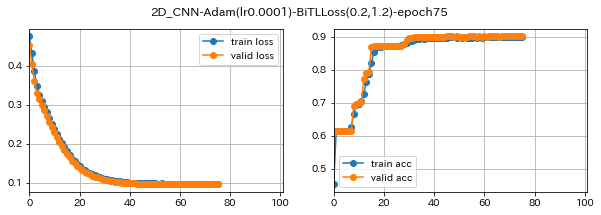

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [31:06<09:46, 24.45s/it]

epoch:  76 



 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [31:31<09:22, 24.47s/it]

 > train loss: 0.09718630951262039   valid loss: 0.09602855925805101
 > train acc: 0.8974119296605714   valid acc: 0.9
 > best acc:  0.9011682242990654
epoch:  77 



 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [31:55<08:57, 24.45s/it]

 > train loss: 0.0970338121550157   valid loss: 0.0960547553601666
 > train acc: 0.8964771864228545   valid acc: 0.9
 > best acc:  0.9011682242990654
epoch:  78 



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [32:20<08:32, 24.43s/it]

 > train loss: 0.09736934448312974   valid loss: 0.09605594599079863
 > train acc: 0.8964771864228545   valid acc: 0.9
 > best acc:  0.9011682242990654
epoch:  79 



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [32:44<08:07, 24.40s/it]

 > train loss: 0.09711083626941437   valid loss: 0.09598997047292852
 > train acc: 0.8984050943506455   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  80 

 > train loss: 0.09692381232456326   valid loss: 0.09596783124676375
 > train acc: 0.8979961441841444   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654


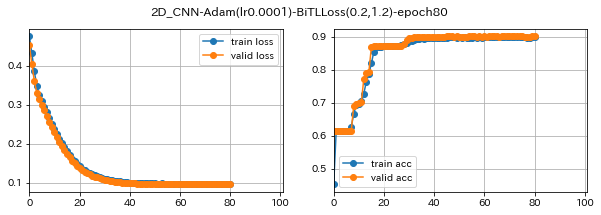

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [33:09<07:44, 24.47s/it]

epoch:  81 



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [33:33<07:20, 24.46s/it]

 > train loss: 0.0969804663814179   valid loss: 0.09591330922095576
 > train acc: 0.8982298299935736   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  82 



 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [33:57<06:55, 24.42s/it]

 > train loss: 0.09721067136899747   valid loss: 0.09597139415618415
 > train acc: 0.8978793012794298   valid acc: 0.9009345794392524
 > best acc:  0.9011682242990654
epoch:  83 



 84%|████████████████████████████████████████████████████████████████████             | 84/100 [34:22<06:30, 24.41s/it]

 > train loss: 0.09692584714180483   valid loss: 0.09593059143451886
 > train acc: 0.8979961441841444   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  84 



 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [34:46<06:05, 24.37s/it]

 > train loss: 0.0967786523376439   valid loss: 0.09591827834042434
 > train acc: 0.8981714085412164   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  85 

 > train loss: 0.09625718241826586   valid loss: 0.09589663363784273
 > train acc: 0.8975871940176433   valid acc: 0.9007009345794392
 > best acc:  0.9011682242990654


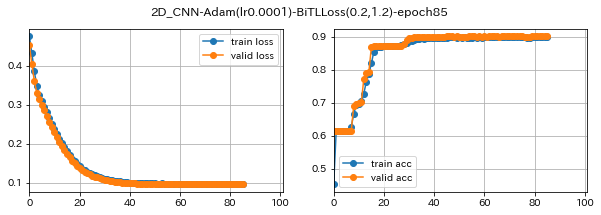

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [35:11<05:41, 24.42s/it]

epoch:  86 



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [35:35<05:17, 24.44s/it]

 > train loss: 0.09731821090735139   valid loss: 0.0959089141443511
 > train acc: 0.8964187649704972   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  87 



 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [36:00<04:53, 24.44s/it]

 > train loss: 0.09725584364674905   valid loss: 0.09585441147612635
 > train acc: 0.896009814803996   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  88 



 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [36:24<04:28, 24.43s/it]

 > train loss: 0.09715499511498843   valid loss: 0.09586254862424369
 > train acc: 0.8965356078752118   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  89 



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [36:48<04:04, 24.41s/it]

 > train loss: 0.09694777094595983   valid loss: 0.09590887856260638
 > train acc: 0.896769293684641   valid acc: 0.9007009345794392
 > best acc:  0.9011682242990654
epoch:  90 

 > train loss: 0.09652769583820245   valid loss: 0.09585228819991941
 > train acc: 0.8978793012794298   valid acc: 0.9009345794392524
 > best acc:  0.9011682242990654


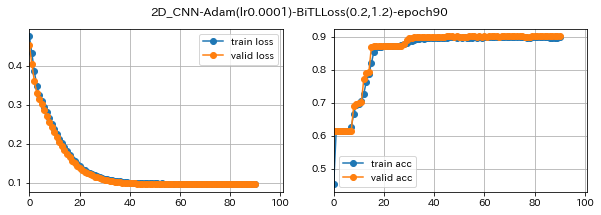

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [37:13<03:40, 24.48s/it]

epoch:  91 



 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [37:37<03:15, 24.47s/it]

 > train loss: 0.09674601430173385   valid loss: 0.09578509921225432
 > train acc: 0.8984635158030029   valid acc: 0.9009345794392524
 > best acc:  0.9011682242990654
epoch:  92 



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [38:02<02:51, 24.46s/it]

 > train loss: 0.09698808361309505   valid loss: 0.09578056612582965
 > train acc: 0.8974703511129287   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  93 



 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [38:26<02:26, 24.43s/it]

 > train loss: 0.0966060310188678   valid loss: 0.0959065274518227
 > train acc: 0.8972366653034994   valid acc: 0.900233644859813
 > best acc:  0.9011682242990654
epoch:  94 



 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [38:51<02:01, 24.39s/it]

 > train loss: 0.09693875957776392   valid loss: 0.09584474911756605
 > train acc: 0.8968277151369983   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  95 

 > train loss: 0.0967101839895476   valid loss: 0.0958354853302519
 > train acc: 0.897353508208214   valid acc: 0.9007009345794392
 > best acc:  0.9011682242990654


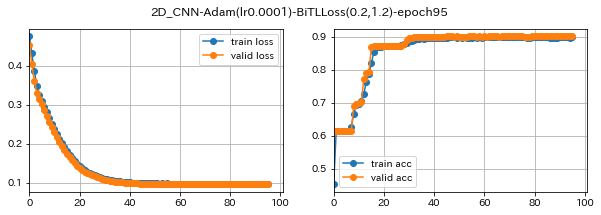

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [39:15<01:37, 24.46s/it]

epoch:  96 



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [39:40<01:13, 24.45s/it]

 > train loss: 0.09659139159778474   valid loss: 0.09580776255542987
 > train acc: 0.8982298299935736   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  97 



 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [40:04<00:48, 24.44s/it]

 > train loss: 0.09681826333872325   valid loss: 0.09581393393400674
 > train acc: 0.8971198223987848   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  98 



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [40:28<00:24, 24.41s/it]

 > train loss: 0.09691890798826436   valid loss: 0.09578165133422781
 > train acc: 0.8977624583747152   valid acc: 0.9004672897196262
 > best acc:  0.9011682242990654
epoch:  99 



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [40:53<00:00, 24.53s/it]

 > train loss: 0.09692852364220463   valid loss: 0.09581870335006268
 > train acc: 0.8971198223987848   valid acc: 0.9007009345794392
 > best acc:  0.9011682242990654


In [10]:
EPOCH_NUM = 100

print(MODEL_NAME)
result = run_training(
                        model=model,
                        optimizer=optimizer,
                        criterion=criterion,
                        epoch_num=EPOCH_NUM,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        MODEL_NAME=MODEL_NAME,
                        device="cuda",
                        verbose=5
                      )